# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV

% matplotlib inline

RANDOM_STATE = 40

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Cleaning and Exploration

The first step will be to better explore the data set, in order to clean and better organize the information before looking for a model that fits well to the problem.

## Portfolio Dataset

In [3]:
# portfolio.json data exploration
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


* Split channels into columns
* Duration appears to be in days
* Offer type categorical, split into columns one-hot encoded

In [4]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


Does not have null values, as described above.

* Rename id to offer_id and use this as table index

In [6]:
def clean_portfolio(df):
    df_clean = df.copy()
    
    df_channel = pd.get_dummies(df_clean['channels'].apply(pd.Series).stack(), prefix='channel').sum(level=0)
    print('(clean_portfolio): Split channel data')
    
    df_clean = pd.concat([df_clean, df_channel], axis=1, sort=False)
    print('(clean_portfolio): Merge two datasets')
    
    df_clean.drop(columns='channels', inplace=True)
    print('(clean_portfolio): Drop original channels column...')
    
    df_offer_type = pd.get_dummies(df_clean['offer_type'].apply(pd.Series).stack(), prefix='offer_type').sum(level=0)
    print('(clean_portfolio): Split offer_type data')
    
    df_clean = pd.concat([df_clean, df_offer_type], axis=1, sort=False)
    print('(clean_portfolio): Merge two datasets')
    
    df_clean.rename(columns={'id':'offer_id'}, inplace=True)
    print('(clean_portfolio): Rename id to offer_id...')

    return df_clean

In [7]:
# clean portfolio dataset
portfolio_cleaned = clean_portfolio(portfolio)

(clean_portfolio): Split channel data
(clean_portfolio): Merge two datasets
(clean_portfolio): Drop original channels column...
(clean_portfolio): Split offer_type data
(clean_portfolio): Merge two datasets
(clean_portfolio): Rename id to offer_id...


In [8]:
portfolio_cleaned.head(10)

,difficulty,duration,offer_id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,0,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,0,1,0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,0,1,0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0,0,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,1,0,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1,0,1,0


In [9]:
# group common offers
portfolio_cleaned.groupby('offer_type')['offer_id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: offer_id, dtype: int64

We can see that there are 3 different types of offers that can be offered to the company's customers.

## Profile Dataset

In [10]:
# profile.json data exploration
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


* Check and correct non-existent values
* Rename id to customer_id
* Add dummy column for gender
* Convert became_member_on to date field

In [11]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [12]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [13]:
def distplot_by_gender(dataframe=None, column=None, title=None):
    if title:
        plt.title(title)
    sns.distplot(dataframe[dataframe["gender"]=='F'][column], label='F')
    sns.distplot(dataframe[dataframe["gender"]=='M'][column], label='M')
    plt.legend()
    plt.gca().get_yaxis().set_visible(False)

In [14]:
def clean_profile(df):
    df_clean = df.copy()
    
    became_member_on = lambda x: pd.to_datetime(str(x), format='%Y%m%d')
    df_clean['became_member_on'] = df_clean['became_member_on'].apply(became_member_on)
    print('(clean_profile): Fix became_member_on field to date...')
    
    became_member_on_year = lambda x: x.year if x else None
    df_clean['became_member_on_year'] = df_clean['became_member_on'].apply(became_member_on_year)
    print('(clean_profile): Add became_member_on_year...')
    
    gender = lambda x: x if not x == None else "O"
    df_clean['gender'] = df_clean['gender'].apply(gender)
    print('(clean_profile): Fix gender to add other value...')
    
    df_gender = pd.get_dummies(df_clean['gender'], prefix='gender')
    df_clean = pd.concat([df_clean, df_gender], axis=1, sort=False)
    print('(clean_profile): Gender column dummy...')
    
    df_clean.rename(columns={'id':'customer_id'}, inplace=True)
    return df_clean

In [15]:
# clean profile dataset
profile_cleaned = clean_profile(profile)

(clean_profile): Fix became_member_on field to date...
(clean_profile): Add became_member_on_year...
(clean_profile): Fix gender to add other value...
(clean_profile): Gender column dummy...


In [16]:
profile_cleaned.head()

,age,became_member_on,gender,customer_id,income,became_member_on_year,gender_F,gender_M,gender_O
0,118,2017-02-12,O,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,0,0,1
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,1,0,0
2,118,2018-07-12,O,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,0,0,1
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,1,0,0
4,118,2017-08-04,O,a03223e636434f42ac4c3df47e8bac43,NaN,2017,0,0,1


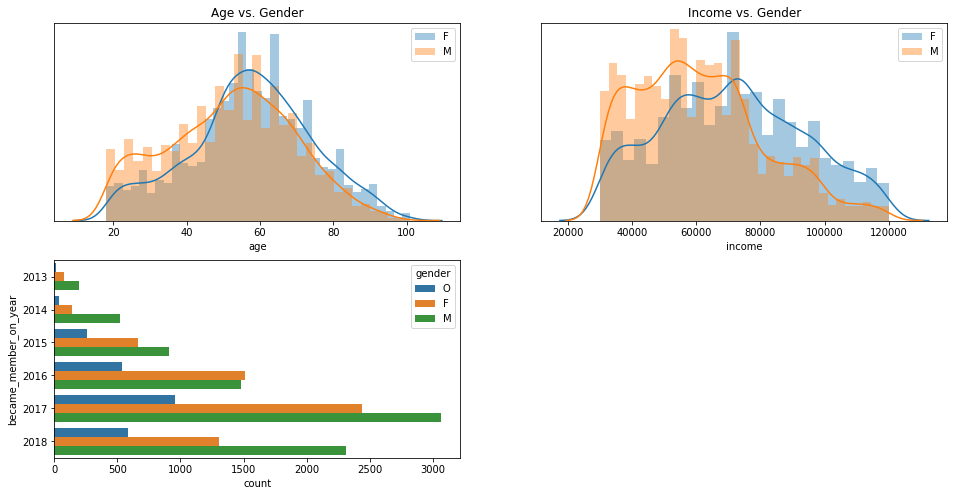

In [17]:
plt.figure(figsize=(16,8))
plt.subplot(221)
distplot_by_gender(dataframe=profile_cleaned, column='age', title='Age vs. Gender')
plt.subplot(222)
distplot_by_gender(dataframe=profile_cleaned, column='income', title='Income vs. Gender')
plt.subplot(223)
sns.countplot(y='became_member_on_year', data=profile_cleaned, hue='gender');

## Transcript Dataset

In [18]:
# transcript.json data exploration
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [19]:
transcript.tail()

,event,person,time,value
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,714,{'amount': 1.5899999999999999}
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,714,{'amount': 9.53}
306531,transaction,a00058cf10334a308c68e7631c529907,714,{'amount': 3.61}
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,{'amount': 3.5300000000000002}
306533,transaction,c02b10e8752c4d8e9b73f918558531f7,714,{'amount': 4.05}


In [20]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


* Adjust event keys to transform one-hot encoded feature
* Split offer_id column 
* Split amount column
* Rename person to customer_id

In [21]:
def clean_transcript(df):
    df_clean = df.copy()
    
    df_clean['event'] = df_clean['event'].str.replace(' ', '_')
    print('(clean_transcript): Adjust event value...')
    
    df_clean['offer_id'] = [[*i.values()][0] if [*i.keys()][0] in ['offer id', 'offer_id'] else None for i in df_clean.value]
    print('(clean_transcript): offer_id column clean...')
    
    df_clean.rename(columns={'person':'customer_id'}, inplace=True)
    print('(clean_transcript): Rename person to customer_id column...')
    
    df_clean['offer_id'].fillna(0.0, inplace=True)
    print('(clean_transcript): Fill offer_id...')
    
    df_clean['amount'] = [np.round([*i.values()][0], decimals=2) if [*i.keys()][0] == 'amount' else None for i in df_clean.value]
    print('(clean_transcript): amount column clean...')
    
    df_clean.drop(columns='value', inplace=True)
    print('(clean_transcript): Drop value column...')
    
    df_clean['amount'].fillna(0.0, inplace=True)
    print('(clean_transcript): Fill amount...')
    
    df_clean = df_clean.groupby(['customer_id','offer_id','event'])['time'].count().unstack()
    df_clean.reset_index(level=[0,1], inplace=True)
    print('(clean_transcript): Consolidate customer events...')
    
    # A user can receive an offer, never actually view the offer, and still complete the offer
    # but to be successful we only should consider when event_offer_viewed and event_offer_completed
    df_clean['successful'] = df_clean['offer_completed'] * df_clean['offer_viewed']
    df_clean['successful'] = df_clean['successful'].apply(lambda x: 1.0 if x > 0 else 0.0)
    print('(clean_transcript): Add successful column calculated...')
    
    df_clean.drop(['offer_completed','offer_received','offer_viewed'],axis=1, inplace = True)
    print('(clean_transcript): Drop event columns...')
        
    return df_clean

In [22]:
# clean transcript dataset
transcript_cleaned = clean_transcript(transcript)

(clean_transcript): Adjust event value...
(clean_transcript): offer_id column clean...
(clean_transcript): Rename person to customer_id column...
(clean_transcript): Fill offer_id...
(clean_transcript): amount column clean...
(clean_transcript): Drop value column...
(clean_transcript): Fill amount...
(clean_transcript): Consolidate customer events...
(clean_transcript): Add successful column calculated...
(clean_transcript): Drop event columns...


In [23]:
transcript_cleaned.head()

event,customer_id,offer_id,transaction,successful
0,0009655768c64bdeb2e877511632db8f,0,8.0,0.0
1,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,NaN,0.0
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,NaN,0.0
3,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0
4,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,NaN,1.0


In [24]:
transcript_cleaned.tail()

event,customer_id,offer_id,transaction,successful
79861,ffff82501cea40309d5fdd7edcca4a07,0,15.0,0.0
79862,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,1.0
79863,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,NaN,1.0
79864,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,1.0
79865,ffff82501cea40309d5fdd7edcca4a07,fafdcd668e3743c1bb461111dcafc2a4,NaN,1.0


In [25]:
transcript_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79866 entries, 0 to 79865
Data columns (total 4 columns):
customer_id    79866 non-null object
offer_id       79866 non-null object
transaction    16578 non-null float64
successful     79866 non-null float64
dtypes: float64(2), object(2)
memory usage: 2.4+ MB


In [26]:
transcript_cleaned.describe()

event,transaction,successful
count,16578.000000,79866.000000
mean,8.381771,0.306263
std,5.009822,0.460943
min,1.000000,0.000000
25%,5.000000,0.000000
50%,7.000000,0.000000
75%,11.000000,1.000000
max,36.000000,1.000000


# Exploratory Visualization

In [27]:
def merge_df(portfolio_df, profile_df, transcript_df):
    # perform a first merge with transcript customer_id with profile
    merge1_df = pd.merge(transcript_df, profile_df, on='customer_id', how="left")
    # perform a second merge with previous merge and portfolio
    merge2_df = pd.merge(merge1_df, portfolio_df, on='offer_id', how="left")
    
    return merge2_df

In [28]:
# merge all datasets into a complete
df = merge_df(portfolio_cleaned, profile_cleaned, transcript_cleaned)

In [29]:
def offer_label(cleaned_df):
    # map offer_id with more friendly name
    offer_id = {'0b1e1539f2cc45b7b9fa7c272da2e1d7': 'DISCOUNT_1',
                '2298d6c36e964ae4a3e7e9706d1fb8c2': 'DISCOUNT_2',
                'fafdcd668e3743c1bb461111dcafc2a4': 'DISCOUNT_3',
                '2906b810c7d4411798c6938adc9daaa5': 'DISCOUNT_4',
                '3f207df678b143eea3cee63160fa8bed': 'INFORM_1',
                '5a8bc65990b245e5a138643cd4eb9837': 'INFORM_2',
                'ae264e3637204a6fb9bb56bc8210ddfd': 'BOGO_1',
                '4d5c57ea9a6940dd891ad53e9dbe8da0': 'BOGO_2',
                '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'BOGO_3',
                'f19421c1d4aa40978ebb69ca19b0e20d': 'BOGO_4'}
    
    cleaned_df['offer_label'] = df['offer_id'].apply(lambda x: offer_id[x] if x else None)
    
    df_offer_label = pd.get_dummies(cleaned_df['offer_label'], prefix='offer_label')
    cleaned_df = pd.concat([cleaned_df, df_offer_label], axis=1, sort=False)
    print('(clean_transcript): Offer label dummy...')
    
    return cleaned_df

In [30]:
# categorize witha friendly name offers
df = offer_label(df)

(clean_transcript): Offer label dummy...


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79866 entries, 0 to 79865
Data columns (total 34 columns):
customer_id                 79866 non-null object
offer_id                    79866 non-null object
transaction                 16578 non-null float64
successful                  79866 non-null float64
age                         79866 non-null int64
became_member_on            79866 non-null datetime64[ns]
gender                      79866 non-null object
income                      69714 non-null float64
became_member_on_year       79866 non-null int64
gender_F                    79866 non-null uint8
gender_M                    79866 non-null uint8
gender_O                    79866 non-null uint8
difficulty                  63288 non-null float64
duration                    63288 non-null float64
offer_type                  63288 non-null object
reward                      63288 non-null float64
channel_email               63288 non-null float64
channel_mobile              632

In [32]:
df.head()

,customer_id,offer_id,transaction,successful,age,became_member_on,gender,income,became_member_on_year,gender_F,...,offer_label_BOGO_1,offer_label_BOGO_2,offer_label_BOGO_3,offer_label_BOGO_4,offer_label_DISCOUNT_1,offer_label_DISCOUNT_2,offer_label_DISCOUNT_3,offer_label_DISCOUNT_4,offer_label_INFORM_1,offer_label_INFORM_2
0,0009655768c64bdeb2e877511632db8f,0,8.0,0.0,33,2017-04-21,M,72000.0,2017,0,...,0,0,0,0,0,0,0,0,0,0
1,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,NaN,0.0,33,2017-04-21,M,72000.0,2017,0,...,0,0,0,0,0,0,0,1,0,0
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,NaN,0.0,33,2017-04-21,M,72000.0,2017,0,...,0,0,0,0,0,0,0,0,1,0
3,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,33,2017-04-21,M,72000.0,2017,0,...,0,0,0,0,0,0,0,0,0,1
4,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,NaN,1.0,33,2017-04-21,M,72000.0,2017,0,...,0,0,0,1,0,0,0,0,0,0


In [33]:
df.tail()

,customer_id,offer_id,transaction,successful,age,became_member_on,gender,income,became_member_on_year,gender_F,...,offer_label_BOGO_1,offer_label_BOGO_2,offer_label_BOGO_3,offer_label_BOGO_4,offer_label_DISCOUNT_1,offer_label_DISCOUNT_2,offer_label_DISCOUNT_3,offer_label_DISCOUNT_4,offer_label_INFORM_1,offer_label_INFORM_2
79861,ffff82501cea40309d5fdd7edcca4a07,0,15.0,0.0,45,2016-11-25,F,62000.0,2016,1,...,0,0,0,0,0,0,0,0,0,0
79862,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,1.0,45,2016-11-25,F,62000.0,2016,1,...,0,0,0,0,1,0,0,0,0,0
79863,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,NaN,1.0,45,2016-11-25,F,62000.0,2016,1,...,0,0,0,0,0,0,0,1,0,0
79864,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,1.0,45,2016-11-25,F,62000.0,2016,1,...,0,0,1,0,0,0,0,0,0,0
79865,ffff82501cea40309d5fdd7edcca4a07,fafdcd668e3743c1bb461111dcafc2a4,NaN,1.0,45,2016-11-25,F,62000.0,2016,1,...,0,0,0,0,0,0,1,0,0,0


In [34]:
df.describe()

,transaction,successful,age,income,became_member_on_year,gender_F,gender_M,gender_O,difficulty,duration,...,offer_label_BOGO_1,offer_label_BOGO_2,offer_label_BOGO_3,offer_label_BOGO_4,offer_label_DISCOUNT_1,offer_label_DISCOUNT_2,offer_label_DISCOUNT_3,offer_label_DISCOUNT_4,offer_label_INFORM_1,offer_label_INFORM_2
count,16578.000000,79866.000000,79866.000000,69714.000000,79866.000000,79866.000000,79866.000000,79866.000000,63288.000000,63288.000000,...,79866.000000,79866.000000,79866.000000,79866.000000,79866.000000,79866.000000,79866.000000,79866.000000,79866.000000,79866.000000
mean,8.381771,0.306263,62.432750,65353.157185,2016.632760,0.360617,0.500088,0.139296,7.711572,6.504819,...,0.079809,0.079258,0.079571,0.078406,0.079809,0.079195,0.079283,0.078694,0.079270,0.079133
std,5.009822,0.460943,26.720159,21620.693354,1.178794,0.480182,0.500003,0.346257,5.541480,2.203565,...,0.270998,0.270142,0.270629,0.268812,0.270998,0.270045,0.270181,0.269263,0.270162,0.269947
min,1.000000,0.000000,18.000000,30000.000000,2013.000000,0.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,0.000000,45.000000,49000.000000,2016.000000,0.000000,0.000000,0.000000,5.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,0.000000,58.000000,63000.000000,2017.000000,0.000000,1.000000,0.000000,10.000000,7.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,11.000000,1.000000,73.000000,80000.000000,2017.000000,1.000000,1.000000,0.000000,10.000000,7.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,36.000000,1.000000,118.000000,120000.000000,2018.000000,1.000000,1.000000,1.000000,20.000000,10.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Considering that our solution should focus in successful orders (where they are viewed and completed), it is important to slice the dataframe.

In [35]:
# separate datasets with successful and unsuccessful data
successful_df = df.loc[df['successful'] == 1]
unsuccessful_df = df.loc[df['successful'] == 0]

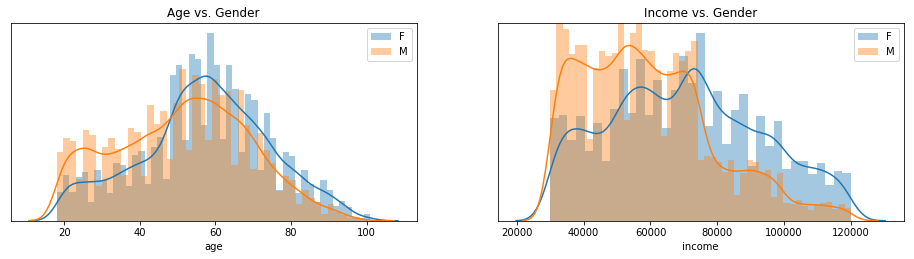

In [36]:
plt.figure(figsize=(16,8))

plt.subplot(221)
distplot_by_gender(dataframe=unsuccessful_df, column='age', title='Age vs. Gender')

plt.subplot(222)
distplot_by_gender(dataframe=unsuccessful_df, column='income', title='Income vs. Gender')

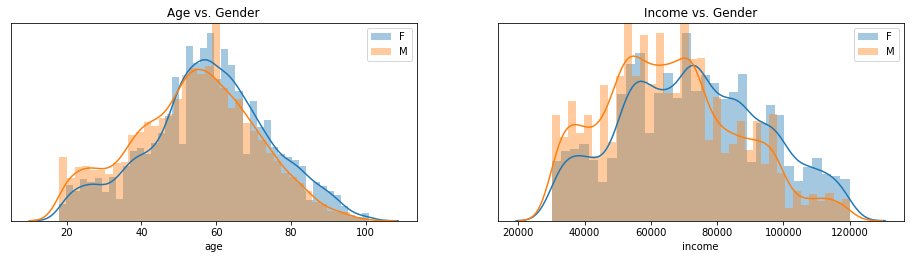

In [37]:
plt.figure(figsize=(16,8))

plt.subplot(221)
distplot_by_gender(dataframe=successful_df, column='age', title='Age vs. Gender')

plt.subplot(222)
distplot_by_gender(dataframe=successful_df, column='income', title='Income vs. Gender')

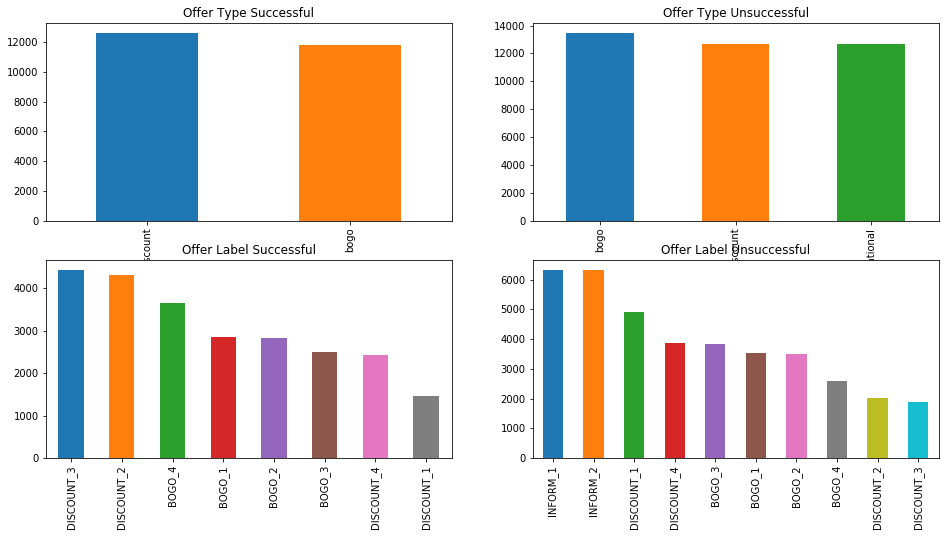

In [38]:
plt.figure(figsize=(16,8))

plt.subplot(221)
plt.title('Offer Type Successful')
successful_df['offer_type'].value_counts().plot(kind='bar')

plt.subplot(222)
plt.title('Offer Type Unsuccessful')
unsuccessful_df['offer_type'].value_counts().plot(kind='bar')

plt.subplot(223)
plt.title('Offer Label Successful')
successful_df['offer_label'].value_counts().plot(kind='bar')

plt.subplot(224)
plt.title('Offer Label Unsuccessful')
unsuccessful_df['offer_label'].value_counts().plot(kind='bar')

(array([    0.,  1000.,  2000.,  3000.,  4000.,  5000.]),
 <a list of 6 Text xticklabel objects>)

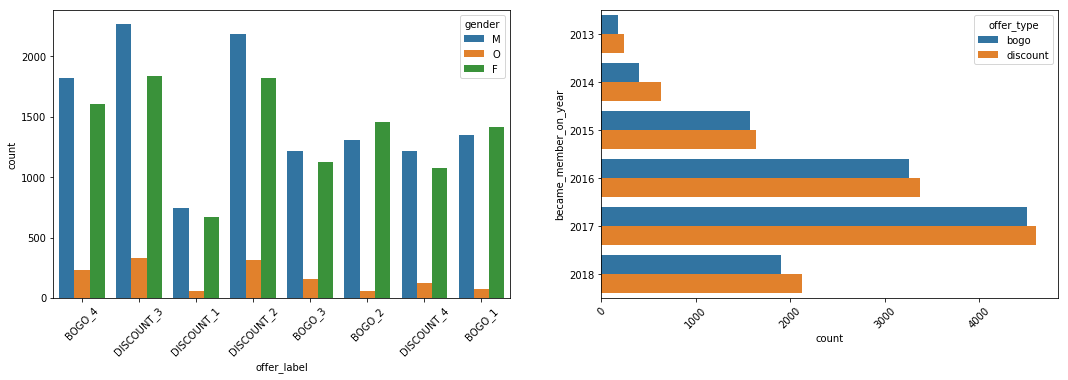

In [39]:
plt.figure(figsize=(18,18))

plt.subplot(321)
sns.countplot(x='offer_label', data=successful_df, hue='gender');
plt.xticks(rotation=45)

plt.subplot(322)
sns.countplot(y='became_member_on_year', data=successful_df, hue='offer_type');
plt.xticks(rotation=45)

In [40]:
df.groupby(['successful','offer_type'])['offer_type'].count()

successful  offer_type   
0.0         bogo             13494
            discount         12683
            informational    12651
1.0         bogo             11827
            discount         12633
Name: offer_type, dtype: int64

# Algorithms and Techniques

## 1. Data Preparation

In [41]:
# check dataset columsn to drop
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79866 entries, 0 to 79865
Data columns (total 34 columns):
customer_id                 79866 non-null object
offer_id                    79866 non-null object
transaction                 16578 non-null float64
successful                  79866 non-null float64
age                         79866 non-null int64
became_member_on            79866 non-null datetime64[ns]
gender                      79866 non-null object
income                      69714 non-null float64
became_member_on_year       79866 non-null int64
gender_F                    79866 non-null uint8
gender_M                    79866 non-null uint8
gender_O                    79866 non-null uint8
difficulty                  63288 non-null float64
duration                    63288 non-null float64
offer_type                  63288 non-null object
reward                      63288 non-null float64
channel_email               63288 non-null float64
channel_mobile              632

In [42]:
df.head()

,customer_id,offer_id,transaction,successful,age,became_member_on,gender,income,became_member_on_year,gender_F,...,offer_label_BOGO_1,offer_label_BOGO_2,offer_label_BOGO_3,offer_label_BOGO_4,offer_label_DISCOUNT_1,offer_label_DISCOUNT_2,offer_label_DISCOUNT_3,offer_label_DISCOUNT_4,offer_label_INFORM_1,offer_label_INFORM_2
0,0009655768c64bdeb2e877511632db8f,0,8.0,0.0,33,2017-04-21,M,72000.0,2017,0,...,0,0,0,0,0,0,0,0,0,0
1,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,NaN,0.0,33,2017-04-21,M,72000.0,2017,0,...,0,0,0,0,0,0,0,1,0,0
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,NaN,0.0,33,2017-04-21,M,72000.0,2017,0,...,0,0,0,0,0,0,0,0,1,0
3,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,33,2017-04-21,M,72000.0,2017,0,...,0,0,0,0,0,0,0,0,0,1
4,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,NaN,1.0,33,2017-04-21,M,72000.0,2017,0,...,0,0,0,1,0,0,0,0,0,0


In [43]:
# Set drop columns
drop_columns = ['customer_id', 'became_member_on', 
                'gender', 'offer_type', 'offer_label', 'offer_id',
                'transaction', 'offer_type_bogo', 'offer_type_discount',
                'offer_type_informational', 'difficulty', 'duration', 'reward']

def clean_df(df, drop_columns=None):
    df_clean = df.copy()
    
    # consider only non transaction events
    df_clean = df_clean.loc[df_clean['offer_id'] != 0]
    
    # drop columns
    df_clean = df_clean.drop(columns=drop_columns, inplace=False, axis=1)
    
    # fill income n/a
    df_clean['income'] = df_clean['income'].fillna(df_clean['income'].mean())
    
    return df_clean

In [44]:
df_cleaned = clean_df(df, drop_columns=drop_columns)

In [45]:
# check columns after cleaning
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63288 entries, 1 to 79865
Data columns (total 21 columns):
successful                63288 non-null float64
age                       63288 non-null int64
income                    63288 non-null float64
became_member_on_year     63288 non-null int64
gender_F                  63288 non-null uint8
gender_M                  63288 non-null uint8
gender_O                  63288 non-null uint8
channel_email             63288 non-null float64
channel_mobile            63288 non-null float64
channel_social            63288 non-null float64
channel_web               63288 non-null float64
offer_label_BOGO_1        63288 non-null uint8
offer_label_BOGO_2        63288 non-null uint8
offer_label_BOGO_3        63288 non-null uint8
offer_label_BOGO_4        63288 non-null uint8
offer_label_DISCOUNT_1    63288 non-null uint8
offer_label_DISCOUNT_2    63288 non-null uint8
offer_label_DISCOUNT_3    63288 non-null uint8
offer_label_DISCOUNT_4    63288 n

In [46]:
# check if there is null values
df_cleaned.isnull().sum()

successful                0
age                       0
income                    0
became_member_on_year     0
gender_F                  0
gender_M                  0
gender_O                  0
channel_email             0
channel_mobile            0
channel_social            0
channel_web               0
offer_label_BOGO_1        0
offer_label_BOGO_2        0
offer_label_BOGO_3        0
offer_label_BOGO_4        0
offer_label_DISCOUNT_1    0
offer_label_DISCOUNT_2    0
offer_label_DISCOUNT_3    0
offer_label_DISCOUNT_4    0
offer_label_INFORM_1      0
offer_label_INFORM_2      0
dtype: int64

In [47]:
df_cleaned.head()

,successful,age,income,became_member_on_year,gender_F,gender_M,gender_O,channel_email,channel_mobile,channel_social,...,offer_label_BOGO_1,offer_label_BOGO_2,offer_label_BOGO_3,offer_label_BOGO_4,offer_label_DISCOUNT_1,offer_label_DISCOUNT_2,offer_label_DISCOUNT_3,offer_label_DISCOUNT_4,offer_label_INFORM_1,offer_label_INFORM_2
1,0.0,33,72000.0,2017,0,1,0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2,0.0,33,72000.0,2017,0,1,0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,0.0,33,72000.0,2017,0,1,0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1
4,1.0,33,72000.0,2017,0,1,0,1.0,1.0,1.0,...,0,0,0,1,0,0,0,0,0,0
5,1.0,33,72000.0,2017,0,1,0,1.0,1.0,1.0,...,0,0,0,0,0,0,1,0,0,0


## 2. Model Pipeline

In [48]:
def model_pipeline(input_df):
    df_copy = input_df.copy()
    
    # scaler
    scaler = MinMaxScaler()
    df_standardized = scaler.fit_transform(df_copy)
    
    # redefine dataeet after sacling
    df_clean = pd.DataFrame(df_standardized, columns=df_copy.columns)
    df_labels = df_clean['successful']
    df_data = df_clean.drop('successful', axis=1)
    
    # shuffel
    train, labels = shuffle(df_data, df_labels, random_state=RANDOM_STATE)
    
    X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.2, random_state=RANDOM_STATE)
    
    return X_train, X_test, y_train, y_test

In [49]:
# cleaning results
X_train, X_test, y_train, y_test = model_pipeline(df_cleaned)

## 3. Training

In [50]:
def train(Model=None, params=None):
    start_time = time.time()

    params = {} if params is None else params
    print("Parameters used with this training:")
    print(params)
    
    model_name = Model.__name__
    model = Model(**params)
    
    # train model
    model.fit(X_train, y_train)
    print(f"Time elapsed for training: {(time.time() - start_time) / 3:.3f} seconds")
    start_time = time.time()
    
    # quality check
    y_predict = model.predict(X_test)
    print(f"Time elapsed for predict: {(time.time() - start_time) / 3:.3f} seconds")
    confusion = confusion_matrix(y_test, y_predict)
    report = classification_report(y_test, y_predict, digits=4)
    accuracy = accuracy_score(y_test, y_predict)
    print(model_name)
    print('Accuracy %.4f' % accuracy)
    print(report)
    sns.heatmap(confusion, fmt='d', annot=True)
    plt.xlabel('Predicted');
    plt.ylabel('True')
    
    
    return model

## 3.1 RandomForestClassifier

In [51]:
rfc_parameters = {'n_estimators':[90, 120], 
                  'max_depth': [2, 4],
                  'min_samples_split': [2, 4]}

rfc = RandomForestClassifier(criterion='entropy', random_state=RANDOM_STATE)

rfc_gscv = GridSearchCV(rfc, rfc_parameters, cv=3, verbose=3, n_jobs=-1)

rfc_gscv.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] max_depth=2, min_samples_split=2, n_estimators=90 ...............
[CV]  max_depth=2, min_samples_split=2, n_estimators=90, score=0.697358 -   0.9s
[CV] max_depth=2, min_samples_split=2, n_estimators=90 ...............


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  max_depth=2, min_samples_split=2, n_estimators=90, score=0.699218 -   0.9s
[CV] max_depth=2, min_samples_split=2, n_estimators=90 ...............


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  max_depth=2, min_samples_split=2, n_estimators=90, score=0.694774 -   0.8s
[CV] max_depth=2, min_samples_split=2, n_estimators=120 ..............
[CV]  max_depth=2, min_samples_split=2, n_estimators=120, score=0.693447 -   1.1s
[CV] max_depth=2, min_samples_split=2, n_estimators=120 ..............
[CV]  max_depth=2, min_samples_split=2, n_estimators=120, score=0.694655 -   1.1s
[CV] max_depth=2, min_samples_split=2, n_estimators=120 ..............
[CV]  max_depth=2, min_samples_split=2, n_estimators=120, score=0.688907 -   1.1s
[CV] max_depth=2, min_samples_split=4, n_estimators=90 ...............
[CV]  max_depth=2, min_samples_split=4, n_estimators=90, score=0.697358 -   0.8s
[CV] max_depth=2, min_samples_split=4, n_estimators=90 ...............
[CV]  max_depth=2, min_samples_split=4, n_estimators=90, score=0.699218 -   0.8s
[CV] max_depth=2, min_samples_split=4, n_estimators=90 ...............
[CV]  max_depth=2, min_samples_split=4, n_estimators=90, score=0.694774 -   0.8s
[CV]

[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   28.4s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=40, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [90, 120], 'max_depth': [2, 4], 'min_samples_split': [2, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=3)

In [52]:
# display best params
rfc_gscv.best_params_

{'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 120}

Parameters used with this training:
{'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 120, 'criterion': 'entropy'}
Time elapsed for training: 0.712 seconds
Time elapsed for predict: 0.030 seconds
RandomForestClassifier
Accuracy 0.7494
             precision    recall  f1-score   support

        0.0     0.7619    0.8563    0.8063      7711
        1.0     0.7224    0.5828    0.6451      4947

avg / total     0.7464    0.7494    0.7433     12658



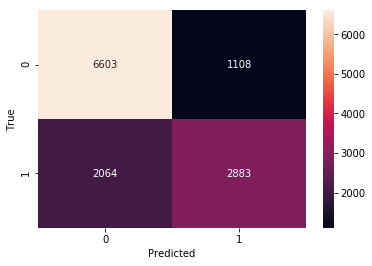

In [53]:
rfc_parameters = {**rfc_gscv.best_params_, 'criterion': 'entropy'}

rfc = train(Model=RandomForestClassifier, params=rfc_parameters)

## 3.2 AdaBoostClassifier

In [54]:
abc_parameters = {'n_estimators': [200, 400], 
                  'learning_rate': [0.15, 0.3]}

abc = AdaBoostClassifier(random_state=RANDOM_STATE)

abc_gscv = GridSearchCV(abc, abc_parameters, cv=3, verbose=3, n_jobs=-1)

abc_gscv.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] learning_rate=0.15, n_estimators=200 ............................
[CV] ... learning_rate=0.15, n_estimators=200, score=0.765671 -   4.6s
[CV] learning_rate=0.15, n_estimators=200 ............................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV] ... learning_rate=0.15, n_estimators=200, score=0.767658 -   4.5s
[CV] learning_rate=0.15, n_estimators=200 ............................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s


[CV] ... learning_rate=0.15, n_estimators=200, score=0.766769 -   4.6s
[CV] learning_rate=0.15, n_estimators=400 ............................
[CV] ... learning_rate=0.15, n_estimators=400, score=0.767686 -   9.2s
[CV] learning_rate=0.15, n_estimators=400 ............................
[CV] ... learning_rate=0.15, n_estimators=400, score=0.768429 -   9.0s
[CV] learning_rate=0.15, n_estimators=400 ............................
[CV] ... learning_rate=0.15, n_estimators=400, score=0.769910 -   9.2s
[CV] learning_rate=0.3, n_estimators=200 .............................
[CV] .... learning_rate=0.3, n_estimators=200, score=0.767804 -   4.7s
[CV] learning_rate=0.3, n_estimators=200 .............................
[CV] .... learning_rate=0.3, n_estimators=200, score=0.768666 -   4.6s
[CV] learning_rate=0.3, n_estimators=200 .............................
[CV] .... learning_rate=0.3, n_estimators=200, score=0.770088 -   4.6s
[CV] learning_rate=0.3, n_estimators=400 .............................
[CV] .

[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=40),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [200, 400], 'learning_rate': [0.15, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=3)

In [55]:
# display best params
abc_gscv.best_params_

{'learning_rate': 0.3, 'n_estimators': 400}

Parameters used with this training:
{'learning_rate': 0.3, 'n_estimators': 400}
Time elapsed for training: 4.294 seconds
Time elapsed for predict: 0.205 seconds
AdaBoostClassifier
Accuracy 0.7676
             precision    recall  f1-score   support

        0.0     0.8106    0.8070    0.8088      7711
        1.0     0.7013    0.7061    0.7037      4947

avg / total     0.7679    0.7676    0.7677     12658



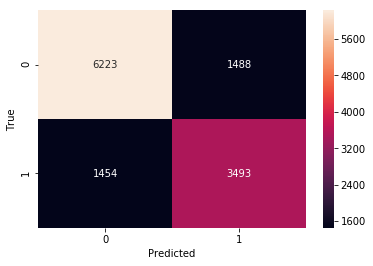

In [56]:
abc = train(Model=AdaBoostClassifier, params=abc_gscv.best_params_)

## 3.3 SVC

Parameters used with this training:
{}
Time elapsed for training: 0.450 seconds
Time elapsed for predict: 0.000 seconds
LinearSVC
Accuracy 0.7475
             precision    recall  f1-score   support

        0.0     0.7922    0.7938    0.7930      7711
        1.0     0.6776    0.6754    0.6765      4947

avg / total     0.7474    0.7475    0.7474     12658



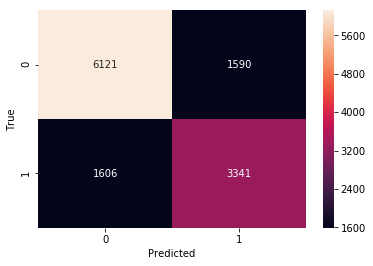

In [57]:
lsvc = train(Model=LinearSVC)

## 3.4 GradientBoostingClassifier

In [58]:
gbc_parameters = {'n_estimators': [200, 400], 
                  'learning_rate': [0.15, 0.3],
                  'max_depth': [2, 4]}

gbc = GradientBoostingClassifier(random_state=RANDOM_STATE)

gbc_gscv = GridSearchCV(gbc, gbc_parameters, cv=3, verbose=3, n_jobs=-1)

gbc_gscv.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] learning_rate=0.15, max_depth=2, n_estimators=200 ...............
[CV]  learning_rate=0.15, max_depth=2, n_estimators=200, score=0.775566 -   3.1s
[CV] learning_rate=0.15, max_depth=2, n_estimators=200 ...............


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV]  learning_rate=0.15, max_depth=2, n_estimators=200, score=0.775302 -   3.1s
[CV] learning_rate=0.15, max_depth=2, n_estimators=200 ...............


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s


[CV]  learning_rate=0.15, max_depth=2, n_estimators=200, score=0.774473 -   3.3s
[CV] learning_rate=0.15, max_depth=2, n_estimators=400 ...............
[CV]  learning_rate=0.15, max_depth=2, n_estimators=400, score=0.776455 -   6.9s
[CV] learning_rate=0.15, max_depth=2, n_estimators=400 ...............
[CV]  learning_rate=0.15, max_depth=2, n_estimators=400, score=0.774413 -   6.6s
[CV] learning_rate=0.15, max_depth=2, n_estimators=400 ...............
[CV]  learning_rate=0.15, max_depth=2, n_estimators=400, score=0.775480 -   6.0s
[CV] learning_rate=0.15, max_depth=4, n_estimators=200 ...............
[CV]  learning_rate=0.15, max_depth=4, n_estimators=200, score=0.776632 -   7.2s
[CV] learning_rate=0.15, max_depth=4, n_estimators=200 ...............
[CV]  learning_rate=0.15, max_depth=4, n_estimators=200, score=0.775302 -   7.1s
[CV] learning_rate=0.15, max_depth=4, n_estimators=200 ...............
[CV]  learning_rate=0.15, max_depth=4, n_estimators=200, score=0.775895 -   7.0s
[CV] le

[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  3.1min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=40, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [200, 400], 'learning_rate': [0.15, 0.3], 'max_depth': [2, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=3)

In [59]:
# display best params
gbc_gscv.best_params_

{'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 200}

Parameters used with this training:
{'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 200}
Time elapsed for training: 3.573 seconds
Time elapsed for predict: 0.016 seconds
GradientBoostingClassifier
Accuracy 0.7770
             precision    recall  f1-score   support

        0.0     0.8121    0.8247    0.8184      7711
        1.0     0.7200    0.7026    0.7112      4947

avg / total     0.7761    0.7770    0.7765     12658



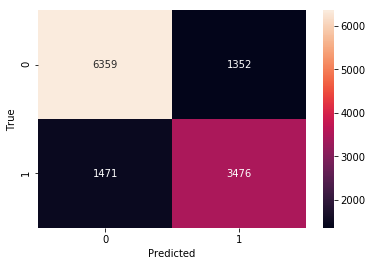

In [60]:
gbc = train(Model=GradientBoostingClassifier, params=gbc_gscv.best_params_)

## 3.5 LogisticRegression

In [61]:
lreg_parameters = {'penalty': ['l1','l2'], 'C': [10, 120, 240]}

lreg = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE)

lreg_gscv = GridSearchCV(lreg, lreg_parameters, cv=3, verbose=3, n_jobs=-1)

lreg_gscv.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] C=10, penalty=l1 ................................................
[CV] ....................... C=10, penalty=l1, score=0.751866 -   1.7s
[CV] C=10, penalty=l1 ................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] ....................... C=10, penalty=l1, score=0.751007 -   1.8s
[CV] C=10, penalty=l1 ................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] ....................... C=10, penalty=l1, score=0.756163 -   2.5s
[CV] C=10, penalty=l2 ................................................
[CV] ....................... C=10, penalty=l2, score=0.751866 -   0.2s
[CV] C=10, penalty=l2 ................................................
[CV] ....................... C=10, penalty=l2, score=0.751007 -   0.2s
[CV] C=10, penalty=l2 ................................................
[CV] ....................... C=10, penalty=l2, score=0.756281 -   0.2s
[CV] C=120, penalty=l1 ...............................................
[CV] ...................... C=120, penalty=l1, score=0.751866 -   0.2s
[CV] C=120, penalty=l1 ...............................................
[CV] ...................... C=120, penalty=l1, score=0.751067 -   0.2s
[CV] C=120, penalty=l1 ...............................................
[CV] ...................... C=120, penalty=l1, score=0.756222 -   0.2s
[CV] C=120, penalty=l2 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    9.3s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=40, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [10, 120, 240]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=3)

In [62]:
# display best params
lreg_gscv.best_params_

{'C': 10, 'penalty': 'l2'}

Parameters used with this training:
{'solver': 'liblinear', 'C': 10, 'penalty': 'l2'}
Time elapsed for training: 0.105 seconds
Time elapsed for predict: 0.000 seconds
LogisticRegression
Accuracy 0.7483
             precision    recall  f1-score   support

        0.0     0.7930    0.7942    0.7936      7711
        1.0     0.6784    0.6768    0.6776      4947

avg / total     0.7482    0.7483    0.7482     12658



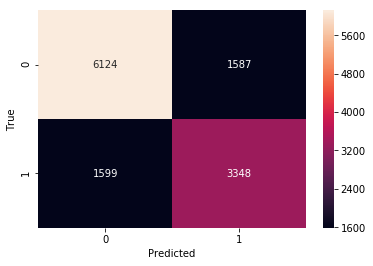

In [63]:
lreg = train(Model=LogisticRegression, params={'solver': 'liblinear', **lreg_gscv.best_params_})

# Benchmark

| Model                      | Training (s) | Predict (s) | Accuracy | Precision | Recall | F1 Score |
|----------------------------|--------------|-------------|----------|-----------|--------|----------|
| LogisticRegression         | 0.108        | 0.000       | 0.7483   | 0.7482    | 0.7483 | 0.7482   |

# Results

| Model                      | Training (s) | Predict (s) | Accuracy | Precision | Recall | F1 Score |
|----------------------------|--------------|-------------|----------|-----------|--------|----------|
| RandomForestClassifier     | 0.712        | 0.032       | 0.7430   | 0.7394    | 0.7430 | 0.7380   |
| AdaBoostClassifier         | 4.187        | 0.225       | 0.7676   | 0.7679    | 0.7676 | 0.7677   |
| SVC                        | 0.364        | 0.000       | 0.7475   | 0.7474    | 0.7475 | 0.7474   |
| GradientBoostingClassifier | 3.850        | 0.016       | 0.7770   | 0.7761    | 0.7770 | 0.7765   |